## 1. load data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

In [2]:
notebook_dir = os.path.dirname(os.path.realpath('baseline_models.ipynb'))

In [3]:
"""
root = str(os.path.dirname(os.path.realpath('baseline_models.ipynb')))
root = root[1:] + '/'

br_path = '/' +os.path.join(root, "Data/Brixia/Brixia images size 224 arrays.npy")
df_brixia = np.load(br_path)

nih_path = '/' + os.path.join(root,"Data/NIHCXR/image1/NIHCXR images size 224 arrays.npy")
df_nihcxr = np.load(nih_path)

co_path_1 = '/' + os.path.join(root,"Data/COVIDGR_1.0/COVID Positive Array 224.npy")
co_path_2 = '/' + os.path.join(root,"Data/COVIDGR_1.0/COVID Negative Array 224.npy")
df_covidgr_pos = np.load(co_path_1)
df_covidgr_neg = np.load(co_path_2)"""
df_brixia = np.load("Brixia images size 224 arrays.npy")
df_nihcxr = np.load("NIHCXR images size 224 arrays.npy")


## 2. Baseline model - CNN

In [4]:
#temporary dataset until preprocessing is done
df_brixia.shape
df_nihcxr.shape

X_train = np.vstack((df_brixia, df_nihcxr))
y_train = np.concatenate((np.ones(df_brixia.shape[0]), np.zeros(df_nihcxr.shape[0])))

In [42]:
#We plan to try various filter sizes of the dense layers, 
#different optimizers (Adam/RMSprop), 
#different learning rates, batch sizes, and numbers of epoch. 
#We will also employ early stopping to prevent the model from overfitting. 
#Finally, we will report the accuracies (maybe AUROC in the next milestone)

from tensorflow.keras.layers import Input, GaussianNoise, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from keras.callbacks import EarlyStopping

def create_model(input_shape):
    inp = Input(shape=input_shape)
    x = GaussianNoise(stddev=0.1)(inp)
    x = Conv2D(64, 2, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(64, 2, activation='relu', padding='same')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, 2, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(128, 2, activation='relu', padding='same')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(128, 2, activation='relu', padding='same')(x)
    x = Conv2D(129, 2, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(256, 2, activation='relu', padding='same')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(256, 2, activation='relu', padding='same')(x)
    x = Conv2D(256, 2, activation='relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[inp], outputs=out)
    return model

def compile_and_train_model(model, optimizer, learning_rate, batch_size, X_train, y_train, epochs):
    es = EarlyStopping(monitor='loss', patience=5, verbose=0,
                   mode='auto',restore_best_weights=True)
    opt = optimizer(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[es])
    return history

In [43]:
def plot_helper_accuracy(model, title=None, ax=None, label_train='train', label_val='val'):
    if ax is None:
        ax = plt.gca()
    ax.plot(model.history.history['accuracy'], label='train')
    ax.plot(model.history.history['val_accuracy'], label='validation')
    best_val = np.argmax(model.history.history['val_accuracy'])
    best_val_value = np.nanmax(model.history.history['val_accuracy'])
    ax.axvline(np.argmax(model.history.history['val_accuracy']),
                    c='k', ls='--',
                    label=f'best val accuracy: {best_val_value:.2f}')
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    ax.set_title(title)
    ax.legend();

def plot_helper_loss(model, title=None, ax=None, label_train='train', label_val='val'):
    if ax is None:
        ax = plt.gca()
    ax.plot(model.history.history['loss'], label=label_train)
    ax.plot(model.history.history['val_loss'], label=label_val)
    best_val = np.argmin(model.history.history['val_loss'])
    best_val_value = np.nanmin(model.history.history['val_loss'])
    ax.axvline(np.argmin(model.history.history['val_loss']),
                    c='k', ls='--',
                    label=f'best val loss: {best_val_value:.2f}')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_title(title)
    ax.legend();

In [ ]:
input_shape = X_train.shape[1:]

# Test learning rates
learning_rates = [0.001, 0.01, 0.05, 0.1] 
model_list_lr = []
history_list_lr = []
for lr in learning_rates:
    model_lr = create_model(input_shape)
    history = compile_and_train_model(model_lr, tf.keras.optimizers.Adam, lr, 32, X_train, y_train, 20)
    model_list_lr.append(model_lr)
    history_list_lr.append(history)

Epoch 1/2


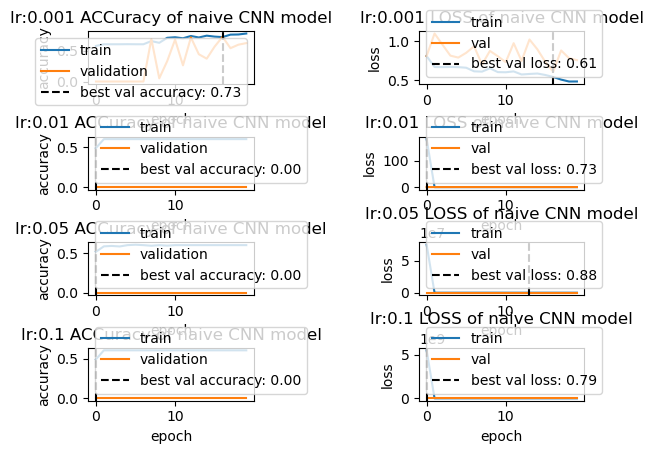

In [38]:
fig, axs = plt.subplots(4, 2)
axs = axs.flatten()
for i, modl in enumerate(model_list_lr):
    plot_helper_accuracy(modl, 
                         title=f'lr:{learning_rates[i]} ACCuracy of naive CNN model', 
                         ax=axs[i*2])
    plot_helper_loss(modl, 
                     title=f'lr:{learning_rates[i]} LOSS of naive CNN model', 
                     ax=axs[i*2+1])
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()


In [11]:
# Test batch sizes
batch_sizes = [32, 64, 128]
model_list_batch = []
history_list_batch = []
for batch in batch_sizes:
    model_batch = create_model(input_shape)
    history = compile_and_train_model(model_batch, tf.keras.optimizers.Adam, 0.001, batch, X_train, y_train, 10)
    model_list_batch.append(model_batch)
    history_list_batch.append(history)

'later, runs too slow\n# Test batch sizes\nbatch_sizes = [32, 64, 128]\nfor bs in batch_sizes:\n    model = create_model(input_shape)\n    history = compile_and_train_model(model, tf.keras.optimizers.Adam, 0.001, bs, X_train, y_train)\n    # Evaluate or store results as needed\n\n# Test optimizers\noptimizers = [tf.keras.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.SGD]\nfor optimizer in optimizers:\n    model = create_model(input_shape)\n    history = compile_and_train_model(model, optimizer, 0.001, 32, X_train, y_train)\n    # Evaluate or store results as needed'

In [ ]:
fig, axs = plt.subplots(4, 2)
axs = axs.flatten()
for i, modl in enumerate(model_list_batch):
    plot_helper_accuracy(modl, 
                         title=f'batch:{batch_sizes[i]} ACCuracy of naive CNN model', 
                         ax=axs[i*2])
    plot_helper_loss(modl, 
                     title=f'batch:{batch_sizes[i]} LOSS of naive CNN model', 
                     ax=axs[i*2+1])
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()


In [ ]:

"""
# Test optimizers -- maybe just ADAM
optimizers = [tf.keras.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.SGD]
for optimizer in optimizers:
    model = create_model(input_shape)
    history = compile_and_train_model(model, optimizer, 0.001, 32, X_train, y_train)
"""


## 3. Grad-CAM

In [ ]:
#Grad-CAM to be implemented later
##Source code: https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353

def GradCAM(model, img, layer, esp=1e-10):
    gradModel = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output,
                model.output])
    
    with tf.GradientTape() as tape:
        # cast the image tensor to a float-32 data type, pass the
        # forward propagate the image through the gradient model, and grab the loss
        # associated with the specific class index
        inputs = tf.cast(img_array, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, 0]
        # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)

    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads

    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]

    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))

    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom

    return heatmap

#GradCAM(model, df_brixia, 'conv2d_2')

#then you need to overlap it on top of the original image or something